In [4]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os

save_metadata_dir = "outputs/metadata/7_2_*/"


imshow_args = {"cmap": "jet"}

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_7_*/sl_merged_*.csv")

In [97]:
paths = os.path.join(save_metadata_dir, "merged_??q_*.csv")
paths = glob(paths)
print(paths)
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)


def minmax_normalize(x: np.ndarray, q=0.99):
    x[x > np.quantile(x, q=q)] = np.quantile(x, q=q)
    return (x - x.min()) / (x.max() - x.min())

['outputs/metadata/7_2_additive_0/merged_igq_metadata.csv']


In [98]:
# set type of merged_data.alpha_mask_value to str
merged_data.alpha_mask_value = merged_data.alpha_mask_value.astype(str)

print(merged_data.q.unique())
print(merged_data.alpha_mask_value.unique())

[70. 30. 90. 50. 10.]
['sl_x2_u_0_0.5']


In [99]:
merged_data = merged_data[merged_data.stream_name == "vanilla_grad_mask"]
merged_data.shape

(5000, 12)

In [100]:
temp = merged_data[merged_data.ig_elementwise == False]
temp.q.value_counts()

q
70.0    1000
30.0    1000
90.0    1000
50.0    1000
10.0    1000
Name: count, dtype: int64

In [101]:
merged_data.alpha_mask_value = merged_data.alpha_mask_value + "_" +\
    merged_data.baseline_mask_type + "_" +\
    merged_data.stream_statistic
merged_data.alpha_mask_value.value_counts()

alpha_mask_value
sl_x2_u_0_0.5_gaussian-0.3_meanx2    5000
Name: count, dtype: int64

In [102]:
merged_data_acc = merged_data.groupby(
    ["alpha_mask_value", "q"])["preds"].mean()
merged_data_acc.name = "Accuracy"
merged_data_acc = merged_data_acc.reset_index()

In [103]:
selection = merged_data_acc.groupby("alpha_mask_value")[
    "Accuracy"].mean().sort_values()
print(selection)
values = selection.values
selection = selection.index
len(selection)

alpha_mask_value
sl_x2_u_0_0.5_gaussian-0.3_meanx2    0.2162
Name: Accuracy, dtype: float64


1

In [26]:
def plot_accuracy_vs_q(selection,
                       figsize=(7, 7),
                       title="untitled",
                       values=None,
                       linestyle_fn=lambda x: None,
                       marker_fn=lambda x: None,
                       color_fn=lambda x: None):
    plt.figure(figsize=figsize)
    # draw vertical lines at ticks
    for q in merged_data_acc.q.unique():
        plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
    # draw horizontal lines at ticks
    plt.ylim(0, 0.7)
    ticks = plt.yticks()[0]
    for acc in ticks:
        plt.axhline(
            acc,
            linestyle=":",
            color="black",
            alpha=0.3,
            linewidth=1,
        )

    for i, alpha in enumerate(selection):
        merged_data_acc_alpha = merged_data_acc[
            merged_data_acc.alpha_mask_value == alpha
        ]
        plt.plot(
            merged_data_acc_alpha.q,
            merged_data_acc_alpha.Accuracy,
            label=alpha+" " +
            f"{values[i]:.3f}" if values is not None else alpha,
            linestyle=linestyle_fn(alpha),
            marker=marker_fn(alpha),
            color=color_fn(alpha),
        )

    # location top right
    plt.legend(loc="upper right")
    plt.xlabel("% of pixels masked")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(f"outputs/figures/{title}.pdf", bbox_inches="tight")

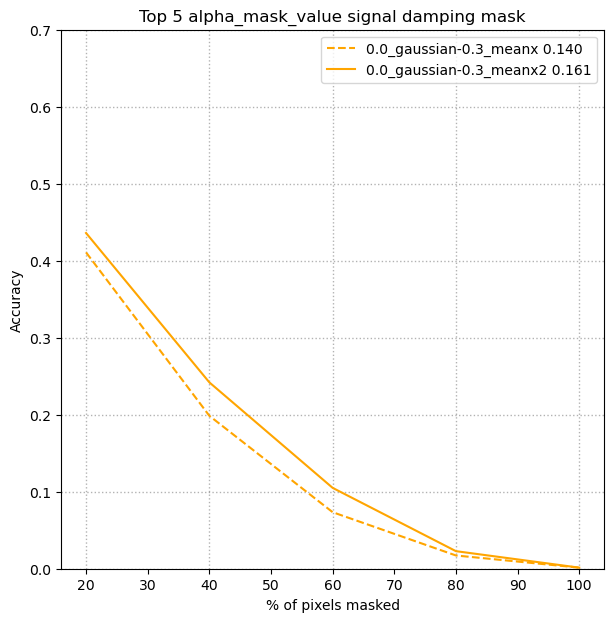

In [27]:
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else "--"
def color_fn(alpha): return "blue" if "ig" in alpha else "orange"


plot_accuracy_vs_q(selection[:5],
                   title="Top 5 alpha_mask_value signal damping mask",
                   values=values[:5],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

2024-02-06:21:48:12,804 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


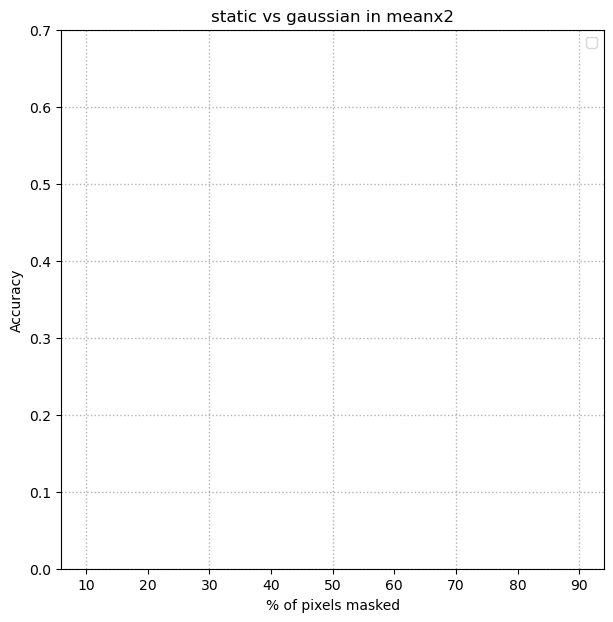

In [82]:
temp_ids = ["meanx2" in s and "ig" not in s and "sl" not in s for s in selection]
colors = plt.cm.jet
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "static" in alpha else "--"
def marker_fn(alpha): return "o" if "norm" in alpha else "x"


plot_accuracy_vs_q(selection[temp_ids],
                   title="static vs gaussian in meanx2",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn,
                   marker_fn=marker_fn)

2024-02-06:17:37:39,609 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


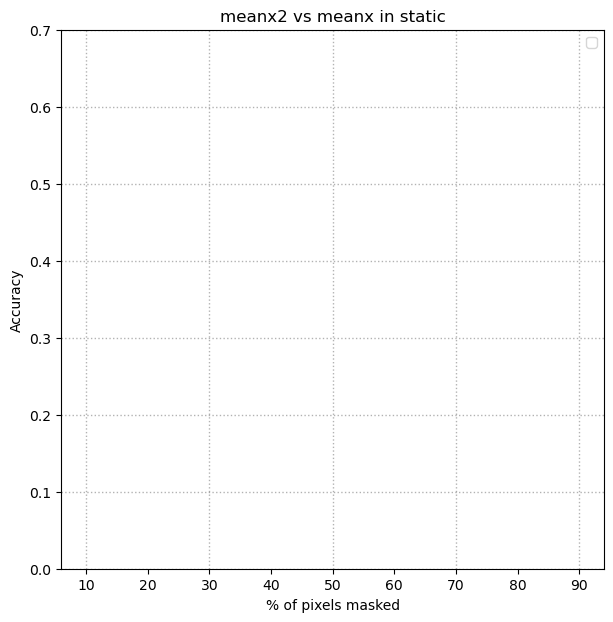

In [13]:
temp_ids = ["static" in s and not "ig" in s for s in selection]
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else "--"


plot_accuracy_vs_q(selection[temp_ids],
                   title="meanx2 vs meanx in static",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

2024-02-06:17:37:41,655 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


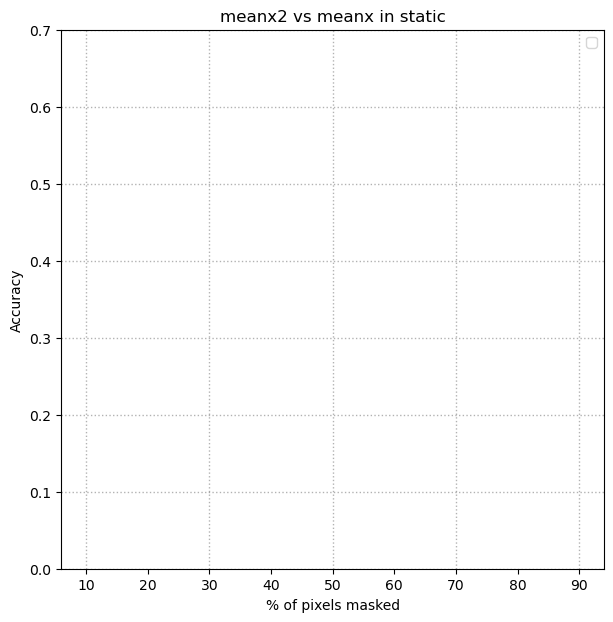

In [14]:
temp_ids = ["gaussian" in s and not "ig" in s and "meanx2" in s and "sl" not in s for i,s in enumerate(selection)]
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else ":"


plot_accuracy_vs_q(selection[temp_ids],
                   title="meanx2 vs meanx in static",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

Text(0.5, 1.0, 'meanx')

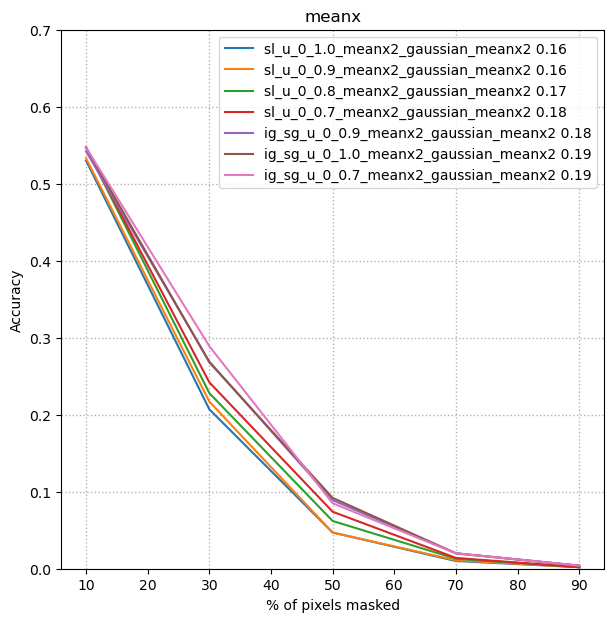

In [15]:
temp_ids = ["ig" in s or "sl" in s for s in selection]
linestyle_fn = lambda x: "-" if "meanx2" in x else "--"
plot_accuracy_vs_q(selection[temp_ids],
                   values=values[temp_ids], title="meanx2 vs meanx",
                   linestyle_fn=linestyle_fn,)
plt.title("meanx")

In [20]:
# stats for vanilla grad
paths = os.path.join(save_metadata_dir, "merged_meq_*.csv")
paths = glob(paths)
print(paths)
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    slq_csv = slq_csv[slq_csv.stream_name == "vanilla_grad_mask"]
    slq_csv = slq_csv.pivot_table(
    index=["alpha_mask_value","stream_statistic"], columns="q", values="preds", aggfunc="mean"
)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)
accs_mean = merged_data.groupby("stream_statistic").mean()
accs_std = merged_data.groupby("stream_statistic").std()
accs_mean.to_csv("outputs/processed/vanilla_grad_accs_mean.csv")
accs_std.to_csv("outputs/proccessed/vanilla_grad_accs_std.csv")
# accs_mean.to_latex("outputs/tables/vanilla_grad_accs_mean.tex", float_format="%.2f")
# accs_std.to_latex("outputs/tables/vanilla_grad_accs_std.tex", float_format="%.2f")
def auc(x):
    return np.trapz(y=x.values, x=x.index/100)
aucs = accs_mean.apply(lambda x: auc(x),axis=1)
# aucs.to_latex("outputs/tables/vanilla_grad_auc.tex", float_format="%.2f")

['outputs/metadata/experiment_7_2_additive_combination_0/merged_meq_metadata.csv', 'outputs/metadata/experiment_7_2_additive_combination_4/merged_meq_metadata.csv', 'outputs/metadata/experiment_7_2_additive_combination_2/merged_meq_metadata.csv', 'outputs/metadata/experiment_7_2_additive_combination_1/merged_meq_metadata.csv', 'outputs/metadata/experiment_7_2_additive_combination_3/merged_meq_metadata.csv']


In [3]:
# plot entropy
save_metadata_dir = "outputs/metadata/7_0_*/"
paths = os.path.join(save_metadata_dir, "predictive_*.csv")
paths = glob(paths)
print(paths)

plt.figure(figsize=(5, 3))
plt.xlim(0, 1)
plt.ylim(0, 3.7)
xticks =plt.xticks()[0]
yticks = plt.yticks()[0]
for x in xticks:
    plt.axvline(x, linestyle=":", color="black", alpha=0.3, linewidth=1)
for y in yticks:
    plt.axhline(y, linestyle=":", color="black", alpha=0.3, linewidth=1)
  
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    slq_csv["combination"] = path.split("/")[-2].split("_")[-2]
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)
merged_data = merged_data.pivot_table(
    index=["alpha_mask_value"],
    columns="combination",
    values="predictive_entropy",
    aggfunc="mean",
)
plt.axvline(0.3, linestyle="--", color="red", linewidth=1,label="critical noise scale")
for combination in merged_data.columns:
    plt.plot(merged_data.index, merged_data[combination], label=combination)
plt.legend()
plt.xlabel(r"Perturbation scale $\sigma$")
plt.ylabel("Predictive entropy")
plt.savefig("outputs/figures/predictive_entropy_g_baseline.pdf", bbox_inches="tight")

NameError: name 'os' is not defined

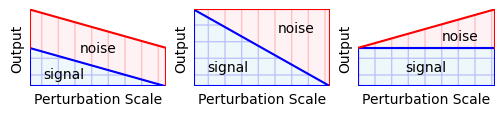

In [6]:
n_rows = 1
n_cols = 3
scale = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale/2),sharey=True, sharex=True)
for i, ax in enumerate(axes):
    ax.set_xlabel("Perturbation Scale")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    # frame off
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_ylabel("Output")

axes[0].plot([1, 0], [0, 0.5], color="blue")
axes[0].plot([0, 0], [0, 0.5], color="blue")
axes[0].plot([1, 0], [0, 0], color="blue")

axes[0].plot([1, 0], [0.5, 1], color="red")
axes[0].plot([0, 0], [0.5, 1], color="red")
axes[0].plot([1, 1], [0, 0.5], color="red")

axes[0].text(0.5, 0.5, "noise", ha="center", va="center")
axes[0].text(0.25, 0.15, "signal", ha="center", va="center")

axes[0].fill_between(
    [0, 1], [0.5, 0],[1, 0.5], color="pink",alpha=0.2, edgecolor="red", hatch="|"
)
axes[0].fill_between(
    [0, 1], [0, 0],[0.5, 0], color="lightblue",alpha=0.2, edgecolor="blue", hatch="+"
)

axes[1].plot([1, 0], [0, 1], color="blue")
axes[1].plot([0, 0], [0, 1], color="blue")
axes[1].plot([1, 0], [0, 0], color="blue")

axes[1].plot([1, 0], [1, 1], color="red")
axes[1].plot([1, 1], [0, 1], color="red")

axes[1].text(0.75, 0.75, "noise", ha="center", va="center")
axes[1].text(0.25, 0.25, "signal", ha="center", va="center")

axes[1].fill_between(
    [0, 1], [1, 0],[1, 1], color="pink",alpha=0.2, edgecolor="red", hatch="|"
)
axes[1].fill_between(
    [0, 1], [0, 0],[1, 0], color="lightblue",alpha=0.2, edgecolor="blue", hatch="+"
)
198

axes[2].plot([1, 0], [0.5, 0.5], color="blue")
axes[2].plot([0, 0], [0, 0.5], color="blue")
axes[2].plot([1, 0], [0, 0], color="blue")
axes[2].plot([1, 1], [0, 0.5], color="blue")

axes[2].plot([0, 1], [0.5, 1], color="red")
axes[2].plot([1, 1], [0.5, 1], color="red")

axes[2].text(0.75, 0.65, "noise", ha="center", va="center")
axes[2].text(0.5, 0.25, "signal", ha="center", va="center")

axes[2].fill_between(
    [0, 1], [0.5, 0.5],[0.5, 1], color="pink",alpha=0.2, edgecolor="red", hatch="|"
)
axes[2].fill_between(
    [0, 1], [0, 0],[0.5, 0.5], facecolor="lightblue",alpha=0.2, edgecolor="blue", hatch="+"
)

plt.show()
fig.savefig("outputs/figures/combination_fns.pdf", bbox_inches="tight")

In [ ]:
actual_qs = merged_data.groupby(["alpha_mask_value", "q"])["actual_q"].mean()
actual_qs = actual_qs.reset_index()
actual_qs[actual_qs.alpha_mask_value.apply(lambda x: "sg_" in x)]

In [10]:
save_metadata_dir = "outputs/metadata/7_0_*/"
paths = os.path.join(save_metadata_dir, "predictive_*.csv")
paths = glob(paths)
print(paths)

(100, 29)
(100, 32)
